# Calibration - broken

Kevin Walchko

---

I made some changes and it broke!!!

We can use `apriltags` to calibrate a camera. 

`cv2.aruco` can detect these tags:

```python
cv2.aruco.DICT_APRILTAG_16H5 = 17
cv2.aruco.DICT_APRILTAG_25h9 = 18
cv2.aruco.DICT_APRILTAG_36H10 = 19
cv2.aruco.DICT_APRILTAG_36H11 = 20
```

In [176]:
# reload library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
import moms_apriltag as apt # generate a target board
import imageio # save the target board to a file for printing
from pathlib import Path
from opencv_camera import __version__ as ocv_version
from opencv_camera import StereoCalibration
from opencv_camera.apriltag.apriltag_marker import Tag
from opencv_camera import ApriltagMarker, ApriltagTargetFinder
print("OpenCV Camera:", ocv_version)

# from math import asin, atan2,pi
from colorama import Fore

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

OpenCV Camera: 0.11.0


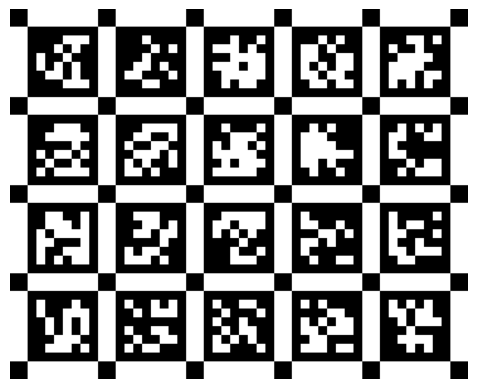

In [178]:
family = "tag36h10"
shape = (4,5)
filename = "apriltag_target.png"
size = 50 # scale image, otherwise a marker is 8x8 pixels

tgt = apt.board(shape, family, size)
imageio.imwrite(filename, tgt)

plt.imshow(tgt, cmap="gray")
plt.axis("off");

Total tags found 20, tag ids:
19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 


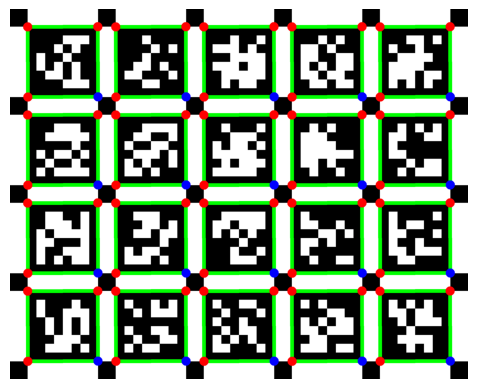

In [179]:
def find(img):
    # ok, img = cv2.threshold(img,150,255,cv2.THRESH_BINARY)
    # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
    # let's double check we can detect the pattern
    corners, ids, rejectedImgPts = aruco.detectMarkers(
        img,
        aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10), 
        parameters=aruco.DetectorParameters_create(),
    )

    # turn the detections into a list of Tags and draw them on the image
    tags = ApriltagMarker.tagArray(ids, corners)
    at = ApriltagMarker()
    img = at.draw(img, tags)

    print(f"Total tags found {len(tags)}, tag ids:")
    for t in tags:
        print(t.tag_id, end=" ")
    print("")
    return img


img = find(tgt)
plt.imshow(img)
plt.axis("off");

In [180]:
corners

(array([[[2499., 1998.],
         [2101., 1999.],
         [2100., 1601.],
         [2498., 1600.]]], dtype=float32),
 array([[[1999., 1998.],
         [1601., 1999.],
         [1600., 1601.],
         [1998., 1600.]]], dtype=float32),
 array([[[1499., 1998.],
         [1101., 1999.],
         [1100., 1601.],
         [1498., 1600.]]], dtype=float32),
 array([[[ 999., 1998.],
         [ 601., 1999.],
         [ 600., 1601.],
         [ 998., 1600.]]], dtype=float32),
 array([[[ 499., 1998.],
         [ 101., 1999.],
         [ 100., 1601.],
         [ 498., 1600.]]], dtype=float32),
 array([[[2499., 1498.],
         [2101., 1499.],
         [2100., 1101.],
         [2498., 1100.]]], dtype=float32),
 array([[[1999., 1498.],
         [1601., 1499.],
         [1600., 1101.],
         [1998., 1100.]]], dtype=float32),
 array([[[1499., 1498.],
         [1101., 1499.],
         [1100., 1101.],
         [1498., 1100.]]], dtype=float32),
 array([[[ 999., 1498.],
         [ 601., 1499.],
      

In [181]:
def blurry(image, threshold=100.0):
    """
    Given an image and threshold, returns if image is blurry and its value
    
    Args:
      image: opencv grayscale image
      threshold: blur threshold value, below this value an image is considered
                 to be blurry
    Return:
      blurry: True/False
      value: numeric value of blurriness
      
    Reference: https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    val = cv2.Laplacian(image, cv2.CV_64F).var()
    val = int(val)
    if val < threshold:
        return True, val
    return False, val

In [182]:
blurry(tgt)

(False, 2084)

In [183]:
files[0].stem

'0'

In [184]:
# help(files[0])

In [185]:
path = Path("cal_imgs")
files = list(path.rglob("*.png"))
func = lambda f: int(f.stem) # 
files = sorted(files, key=func)

imgs = []
for f in files:
    f = str(f)
    imgs.append(cv2.imread(f, 0))

left: (720, 1280) right: (720, 1280)
Found 39 good images out of 44 images


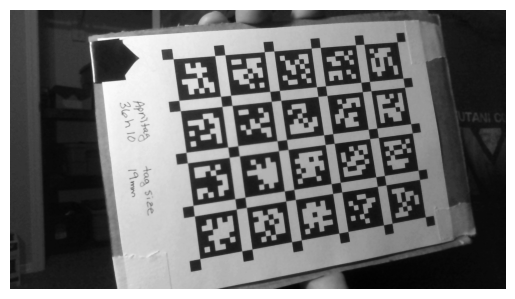

In [186]:
imgsL, imgsR = [], []
h,w = imgs[0].shape

for im in imgs:
    l = im[:, :w//2]
    r = im[:, w//2:]
    
    thres = 300
    bl, val = blurry(l, thres)
    br, val = blurry(r, thres)
    if bl or br:
        continue
    
    imgsL.append(l)
    imgsR.append(r)
    
print(f"left: {imgsL[0].shape} right: {imgsR[0].shape}")
print(f"Found {len(imgsL)} good images out of {len(imgs)} images")
plt.imshow(imgsR[0], cmap="gray")
plt.axis("off");

In [187]:
for i, (l, r) in enumerate(zip(imgsL, imgsR)):
    thres = 100
    blur, val = blurry(l, thres)
    c = Fore.RED if blur is True else ""
    print(f"{c}{i:3}: left: {blur},{val}{Fore.RESET}", end="   ")
    blur, val = blurry(r, thres)
    c = Fore.RED if blur is True else ""
    print(f"{c}right: {blur},{val}{Fore.RESET}")

  0: left: False,390   right: False,367
  1: left: False,378   right: False,323
  2: left: False,623   right: False,621
  3: left: False,618   right: False,553
  4: left: False,611   right: False,534
  5: left: False,647   right: False,339
  6: left: False,526   right: False,621
  7: left: False,434   right: False,362
  8: left: False,478   right: False,343
  9: left: False,551   right: False,356
 10: left: False,422   right: False,580
 11: left: False,516   right: False,608
 12: left: False,580   right: False,567
 13: left: False,426   right: False,397
 14: left: False,450   right: False,430
 15: left: False,473   right: False,458
 16: left: False,359   right: False,373
 17: left: False,413   right: False,383
 18: left: False,477   right: False,440
 19: left: False,515   right: False,470
 20: left: False,413   right: False,384
 21: left: False,367   right: False,349
 22: left: False,315   right: False,309
 23: left: False,338   right: False,354
 24: left: False,489   right: False,463


Total tags found 10, tag ids:
4 3 7 6 12 11 18 17 8 14 
Total tags found 17, tag ids:
3 2 1 7 6 5 12 11 10 19 18 16 15 9 8 14 13 


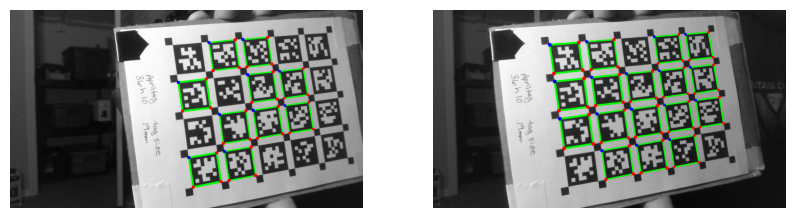

In [188]:
plt.figure(figsize=(10,5))
num = 0
plt.subplot(121); plt.imshow(find(imgsL[num]), cmap="gray");plt.axis("off");
plt.subplot(122); plt.imshow(find(imgsR[num]), cmap="gray");plt.axis("off");

In [199]:
board = ApriltagTargetFinder(size=(4,5), scale=0.019, tagtype=aruco.DICT_APRILTAG_36h10)

cal = StereoCalibration()
ok, cameraModel, stereoCamera = cal.calibrate(imgsL, imgsR, board)

>> RMS: 67.703px

 Camera[(720, 1280)]----------------------
  focalLength(x,y): 9664.8 6966.4 px 
  principlePoint(x,y): 783.9 382.7 px
  distortionCoeffs: [[  -28.216  1899.191    -0.065    -0.203 -8619.524]]

>> RMS: 67.529px

 Camera[(720, 1280)]----------------------
  focalLength(x,y): 52503.8 13398.2 px 
  principlePoint(x,y): 720.5 443.8 px
  distortionCoeffs: [[-74.178  -1.298  -0.251  -0.175  -0.013]]

bad points: (40, 3) (40, 2) (68, 2)
bad points: (56, 3) (56, 2) (64, 2)
bad points: (76, 3) (76, 2) (80, 2)
bad points: (72, 3) (72, 2) (60, 2)
bad points: (80, 3) (80, 2) (60, 2)
bad points: (68, 3) (68, 2) (64, 2)
bad points: (60, 3) (60, 2) (48, 2)
bad points: (76, 3) (76, 2) (60, 2)
bad points: (36, 3) (36, 2) (60, 2)
bad points: (52, 3) (52, 2) (76, 2)
bad points: (64, 3) (64, 2) (72, 2)
bad points: (68, 3) (68, 2) (60, 2)
bad points: (72, 3) (72, 2) (76, 2)
bad points: (80, 3) (80, 2) (76, 2)
bad points: (76, 3) (76, 2) (80, 2)
bad points: (76, 3) (76, 2) (80, 2)
bad poin

In [200]:
print(stereoCamera)

Camera 1 --------------------------
  focalLength(x,y): 53205.0 12627.7 px 
  principlePoint(x,y): 664.2 894.9 px
  distortionCoeffs: [[ -3419.043 -24822.028    -55.425     -0.491  -8787.035]]
Camera 2 --------------------------
  focalLength(x,y): 47711.0 30695.9 px 
  principlePoint(x,y): -854.1 268.0 px
  distortionCoeffs: [[  -14.69    887.219    -0.353    -1.884 -8029.76 ]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [ 1.608  0.312 -6.582]
  Rotation between Left/Right Camera:
    [[ 0.988  0.133 -0.08 ]
     [-0.134  0.991 -0.003]
     [ 0.079  0.013  0.997]]
  Essential Matrix:
    [[-0.856  6.527  0.294]
     [-6.629 -0.898 -1.078]
     [-0.524  1.552  0.021]]
  Fundatmental Matrix:
    [[ 0.    -0.     0.   ]
     [ 0.     0.     0.   ]
     [ 0.    -0.002  1.   ]]



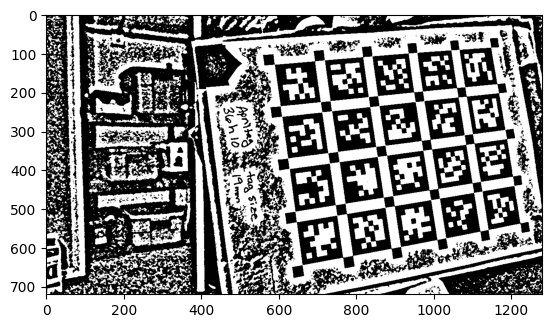

In [173]:
num = 0
# ok, img = cv2.threshold(imgsL[num],150,255,cv2.THRESH_BINARY)
img = cv2.adaptiveThreshold(imgsL[num],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
plt.imshow(img,cmap="gray")

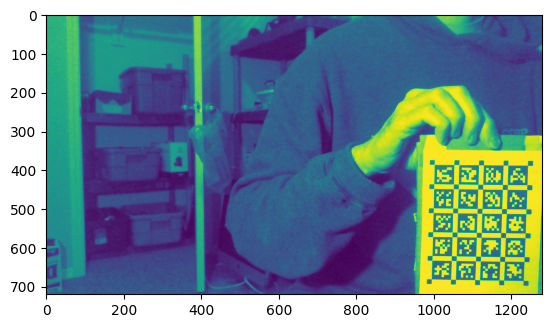

In [148]:
plt.imshow(imgsL[14])